# Imports

In [1]:
import sys, gym
sys.path.append('../..')
from markov.Policies import EpsilonGreedyPolicy, RandomPolicy, QTablePolicy
from markov.Training import Agent, Academy
from markov.Metrics import CumulativeRewardFactory, EpisodeReward,ModelReadiness
from markov.Training import AgentConfig, AgentMetrics
import warnings
warnings.filterwarnings('ignore')

2024-07-07 16:36:54.474978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 16:36:55.361357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Training

#### Actual Training

In [2]:
agent_configs = {
    # "RandomWitness": AgentConfig(
    #     policy   = RandomPolicy()
    # ),
    "Q-g1": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 1)
        ),
        model_readiness=True
    ),
    "Q-g0.8": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0.8)
        ),
        model_readiness=True
    ),
    "Q-g0.6": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0.6)
        ),
        model_readiness=True
    ),
    "Q-g0.4": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0.4)
        ),
        model_readiness=True
    ),
    "Q-g0.2": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0.2)
        ),
        model_readiness=True
    ),
    "Q-g0": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.8,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0)
        ),
        model_readiness=True
    ),
}

academy = Academy(
    env     = gym.make("Taxi-v3"),
    agents  = agent_configs,
    metrics = AgentMetrics(
        step_metrics    = { "CumulativeReward"  : CumulativeRewardFactory() },
        episode_metrics = { "EpisodeReward"     : EpisodeReward },
        model_readiness_metrics  = { "ModelReadiness" :ModelReadiness }

    )
)
training_metrics = academy.Train(1000)
academy.closeEnvs()


#### Compare agent training stats

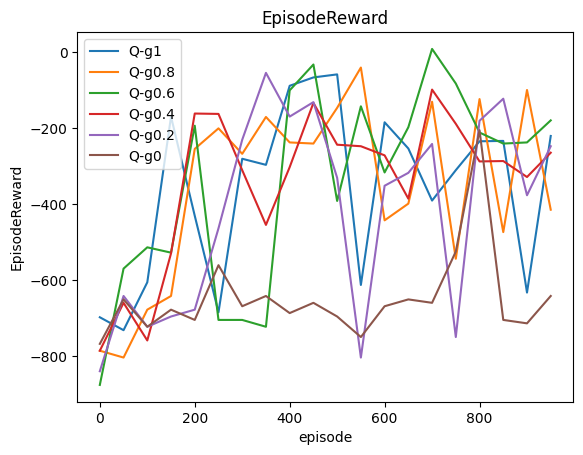

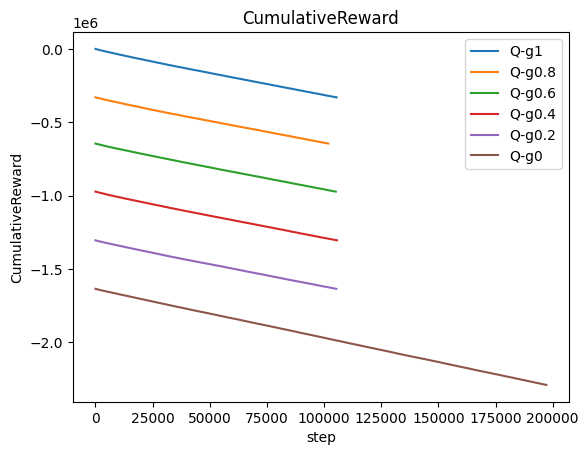

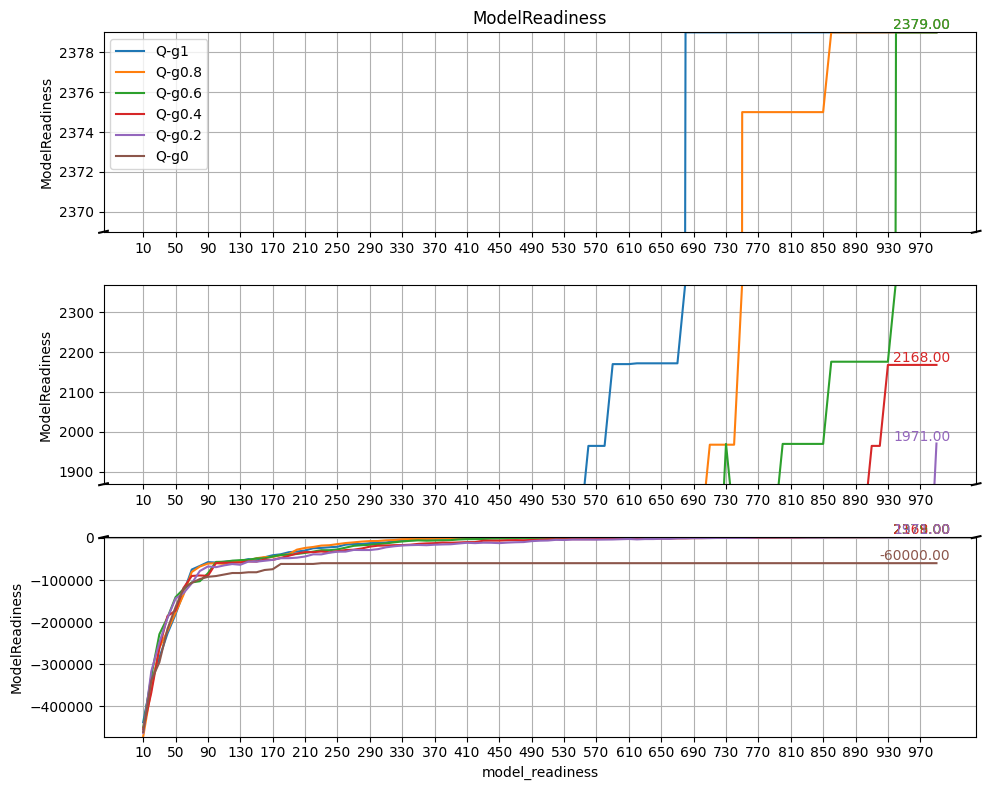

In [3]:
import matplotlib.pyplot as plt
from markov.Comparison import PlotMetricsComparison,PlotMetricsComparisonBrokenAxes

PlotMetricsComparison(
    agent_metrics   = training_metrics,
    type            = "episode",
    step            = 50
)

PlotMetricsComparison(
    agent_metrics   = training_metrics,
    type            = "step",
    step            = 1
)
PlotMetricsComparisonBrokenAxes(
    agent_metrics   = training_metrics,
    type            = "model_readiness",
    step            = 4
)

Notes:
- The CumulativeReward plot of each agent starts where the previous stopped because of an implementation mistake (every agent uses the same closure returned by CumulativeRewardFactory(), therefore using the same accumulator variable ) 
- every agent is trained the same number of episodes, but those learning quicker use less steps since they win each episode faster

# Tests

#### Test a specific agent (Renderer)

In [4]:
from markov.Metrics import EpisodeTerminated
from markov.Training import AgentMetrics

AGENT_TO_TEST   = "Q-g0.8"
EPISODES        = 5

In [5]:
inference_env = gym.make("Taxi-v3", render_mode="human")

inference_metrics = academy.Infere(
    env         = inference_env,
    episodes    = EPISODES,
    agent_name  = AGENT_TO_TEST,
)

state 434 + action 3 => state 334 and reward -1 (On-Going)
state 334 + action 3 => state 234 and reward -1 (On-Going)
state 234 + action 4 => state 254 and reward -1 (On-Going)
state 254 + action 4 => state 274 and reward -1 (On-Going)
state 274 + action 2 => state 374 and reward -1 (On-Going)
state 374 + action 2 => state 474 and reward -1 (On-Going)
state 474 + action 0 => state 478 and reward -1 (On-Going)
state 478 + action 3 => state 378 and reward -1 (On-Going)
state 378 + action 3 => state 278 and reward -1 (On-Going)
state 278 + action 5 => state 258 and reward -1 (On-Going)
state 258 + action 5 => state 238 and reward -1 (On-Going)
state 238 + action 5 => state 218 and reward -1 (On-Going)
state 218 + action 2 => state 318 and reward -1 (On-Going)
state 318 + action 2 => state 418 and reward -1 (On-Going)
state 418 + action 1 => state 410 and reward 20 (Done)
state 192 + action 2 => state 292 and reward -1 (On-Going)
state 292 + action 2 => state 392 and reward -1 (On-Going)
s

In [6]:
inference_env.close()

#### Compare agents

In [7]:
from markov.Metrics import EpisodeTerminated
from markov.Training import AgentMetrics

# inference_env = gym.make("Taxi-v3", render_mode="human")
inference_env = gym.make("Taxi-v3")

inference_metrics = academy.Infere(
    env         = inference_env,
    episodes    = 1000,
    metrics     = AgentMetrics(
        episode_metrics = { 
            "EpisodeReward" : EpisodeReward,
            "EpisodeWon"    : EpisodeTerminated,
        }
    )
)
inference_env.close()

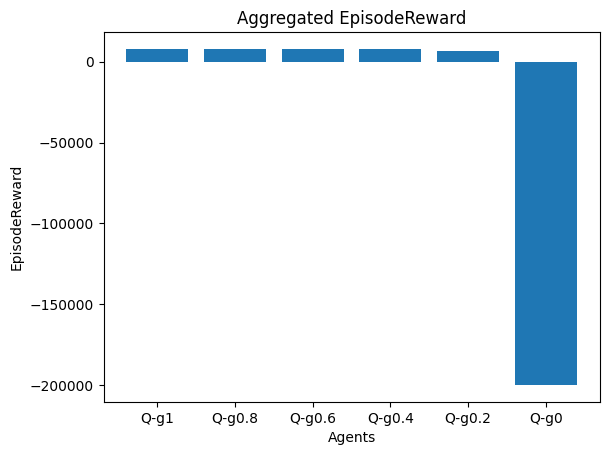

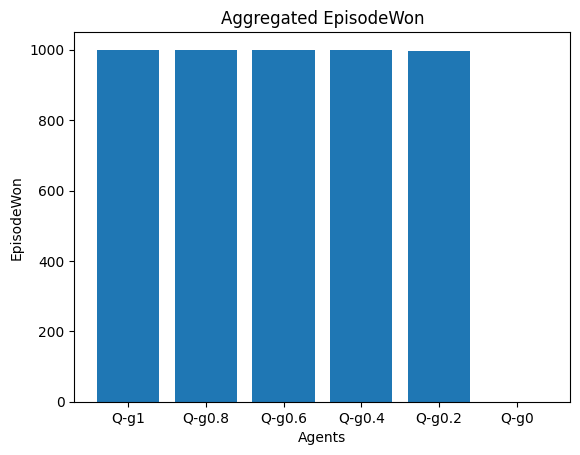

In [8]:
import matplotlib.pyplot as plt
from markov.Comparison import BarAggregatedMetricsComparison, PlotMetricsComparison

BarAggregatedMetricsComparison(
    agent_metrics   = inference_metrics,
    type            = "episode",
    agg             = sum
)


# Conclusion

- The **higher the discount rate is the faster the agent improves** (see `Episode Reward` and `Cumulative Reward` graphs)

- It seems  **all agents converge to a 100% success rate** (see `Aggregated EpisodeWon` : when the number of training episode increseases, so does the score of each agent) except for a those using a null discount rate. This is understandable because a discount of 0 means no vision into the 'future' past the next move, so going closer of further from the objectives is rewarded the same way. 